# Working with Rasters

This notebook walks you through:
- Downloading rasters from EarthByte's webDAV server
- Importing your own raster file
- Plotting rasters
- Reconstructing it back in geological time using `gplately`

Import all needed packages, and create `PlateReconstruction` and Plot objects for the [Muller et al. (2019)]("https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018TC005462) plate tectonic model.

In [2]:
import os

import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from plate_model_manager import PlateModelManager, PresentDayRasterManager

## Downloading a Raster from webDAV server:

We begin by loading our plate model and creating a `PlateReconstruction` and a `PlotTopologies` object.

In [4]:
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="../../data/plate-model-repo")

rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs)

Now we download a raster from EarthByte's webDAV server:

In [5]:
# Set time
time = 0  # Ma

# Download and create a global raster for age grids at 0 Ma
muller_2019_age_grid = gplately.Raster(
    data=muller2019_model.get_raster("AgeGrids", time),
    plate_reconstruction=model,
    extent=[-180, 180, -90, 90],  # Defines the geographical boundaries of the raster grid (entire globe in this case)
)

Unrecognized zip data!


## Importing Your Own Raster

To import your own raster into gplately (e.g., a custom .tif or .nc file), you can use the `gplately.Raster` class directly by reading your raster with a compatible library like `matplotlib.image`, then creating a `gplately.Raster` object.

In this example, we will use the GeoTIFF of Finland obtained from the [PlanetObserver Geospatial Data Samples page]("https://www.planetobserver.com/geospatial-data-samples"). 

In [54]:
from matplotlib import image

# Load your raster file (e.g., a GeoTIFF or image)
# Replace with the path to your raster file
model_data = image.imread("../../data/PlanetObserver_PlanetSAT_10m_Finland_Helsinki_UTM35.tif")  # Or .png, .jpg, etc.

# Create a Raster object
custom_raster = gplately.Raster(
    data=model_data,
    extent=[-180, 180, -90, 90],  # Replace with actual geographic extent
)

## Plotting Rasters

The `muller_2019_age_grid` & `custom_raster` are `Raster` objects; this object allows us to work with age grids and other rasters. Let's visualise the data with `imshow`. 

The color map "YlGnBu" is used to show different values (like ocean crust age) using shades of yellow, green, and blue.

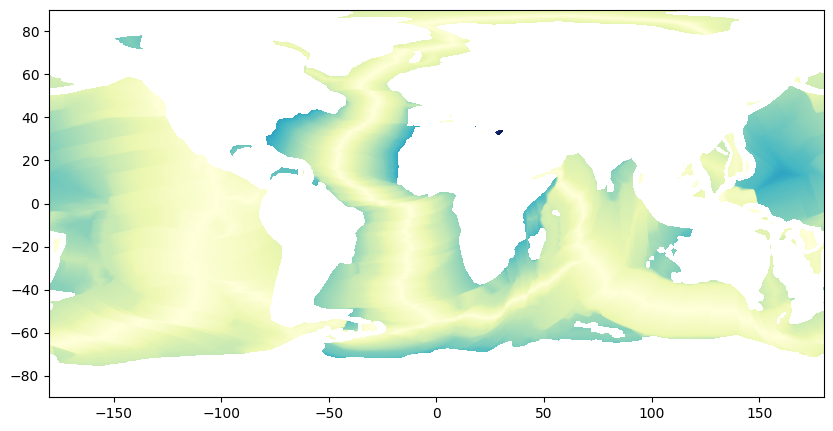

In [23]:
# Create a new figure for the plot, with a custom size
fig = plt.figure(figsize=(10, 6))

# Plot the raster data (age grid) using a color map
muller_2019_age_grid.imshow(cmap="YlGnBu")  # Try "twilight", "plasma" etc!

# Display the plot
plt.show()

Let's plot this netCDF grid along with coastlines, mid-ocean ridges and subduction zones (with teeth) resolved from the Muller et al. 2019 plate model.

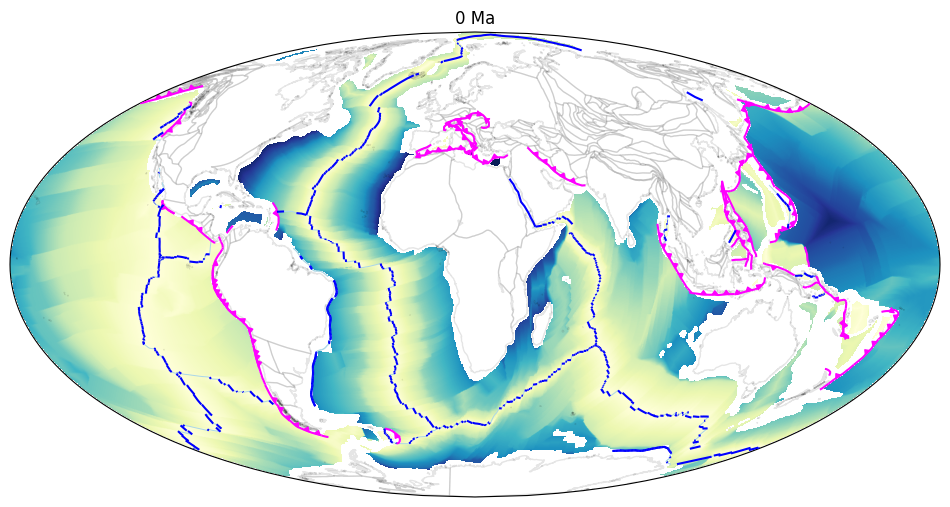

In [53]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=20))

gplot.time = time

muller_2019_age_grid.imshow(ax1, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='1', alpha=0.1)
gplot.plot_trenches(ax1, color='magenta', zorder=5)
gplot.plot_ridges(ax1, color='b', zorder=5)
gplot.plot_transforms(ax1, color='lightblue', linewidth=0.75)
gplot.plot_subduction_teeth(ax1, color='magenta')
ax1.set_title("{} Ma".format(time))
plt.show()

Now let's plot a high-resolution (10m) satellite imagery product of Helsinki (Finland) using the `custom_raster`!

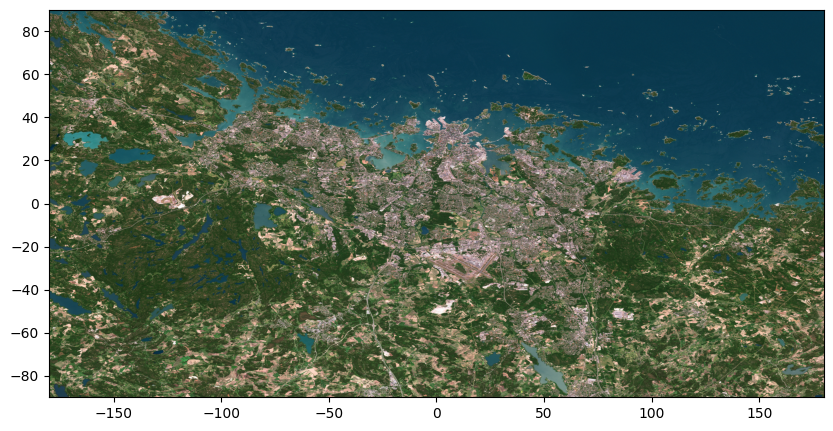

In [ ]:
fig = plt.figure(figsize=(10, 6))

# Plot the raster data (age grid)
custom_raster.imshow()
plt.show()

## Reconstructing Rasters

The `muller_2019_age_grid` raster can be reconstructed back in time by assigning a `plate_reconstruction` to the object. We use the plate reconstruction we defined earlier (`model`). Note that a Raster object will also accept a `plate_reconstruction` at initialisation.

After this, we use `reconstruct` to reconstruct the raster to a given time (in this case, 25 Ma).

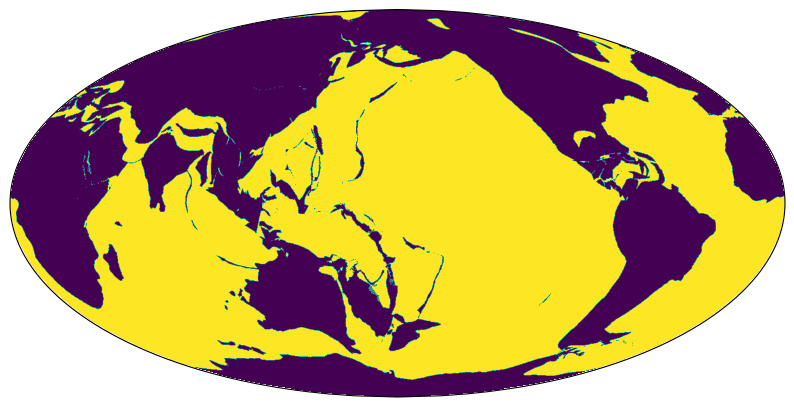

In [56]:
# Assign a plate reconstruction in order to reconstruct the raster
muller_2019_age_grid.plate_reconstruction = model

# Time = 25 Ma, Threads ???
muller_2019_age_grid_reconstructed = muller_2019_age_grid.reconstruct(25, threads=4, fill_value=255)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=180))
muller_2019_age_grid_reconstructed.imshow(ax1)

Rasters can be also be reverse reconstructed forward in time!

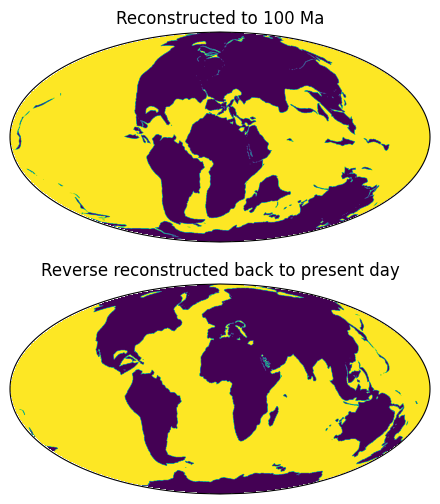

In [ ]:
# Time = 100 Ma
reconstructed = muller_2019_age_grid.reconstruct(100, fill_value=255, threads=4)

# Time = 0 Ma
reverse_reconstructed = reconstructed.reconstruct(0, fill_value=255, threads=4)

# Plots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), subplot_kw={"projection": ccrs.Mollweide(central_longitude=0)})
reconstructed.imshow(ax=axs[0])
reverse_reconstructed.imshow(ax=axs[1])

axs[0].set_title("Reconstructed to 100 Ma")
axs[1].set_title("Reverse reconstructed back to present day")
plt.show()